# Predictivity analysis
After the experiments done in notebook 1 it was decided that we will be using a KNeighbours classifier and splitting our data using the Stratified KFold method in scikit. 

In this notebook the predictivity of data trained using this model will be analysed and cross validated. 

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.ticker import MaxNLocator

In [2]:
def load(fname: str, cv: str) -> tuple:
    """Loads data from a CSV file and splits it using scikit"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Sets up regressor with the type of regressor and type of splitting"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
        # method that predicts new y values from new x data
    def predict(self, newdata):
        """returns predicted value from new X data"""
        y = self.regressor.predict(newdata)
        return y

In [3]:
class postplotter:
    
    #initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self, title: str):
    
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        


        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='viridis')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for i in range(2):
            for j in range(2):

                # leave colour as white as the default
                color = 'black'
                if (i == 2 and j != 2):

                    # when overdose happened but wasn't predicted, changed colour
                    # to red if it is not 0
                    if array[i, j] == 0:
                        color = 'black'

                    else:
                        color = 'black'

                # set colour to black for the light coloured square
                # this is done after plotting once
                elif i == 1 and j == 1:
                    color = 'black'

                # add text with correct colour
                ax.text(j, i, array[i, j], ha='center', va='center', color=color)
        
        #sets axis title
        ax.set_title(title, fontsize=15)

        
        #calculates F1, P and R values
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            P = (array[1,1]/(array[1,1]+array[0,1]))*100
            F1 = 2*P*R/(P+R)
            confresults = pd.DataFrame({'Precision P': P, 'F-score F1': F1, 'Recall R': R }, index=[0])

        else:
            confresults = pd.DataFrame({'Precision P': 'N/A', 'F-score F1': 'N/A', 'Recall R': R }, index=[0])
            print("P and F1 could not be calculated due to 0 total correct guesses")

        print(confresults.to_string(index=False))
    
    def scorer(self):
        """creates score attributes of this class for F1, R and P"""
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        
        self.R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            self.P = (array[1,1]/(array[1,1]+array[0,1]))*100
            self.F1 = 2*self.P*self.R/(self.P+self.R)
        else:
            print("P and F1 could not be calculated due to 0 total correct guesses")



## Changing parameters in the classifier
In this cell we run the KNeighbours classifier with different parameters to see which give us the best score. 

In [4]:
#List Hyperparameters that we want to tune.
leaf_sizel = list(range(1,30))
n_neighborsl = list(range(1,50))
pl=[1,2]

#file we are going to test the regressor on 
fname = 'data/splits/split21.csv'
#empty dictionary to put the scores and their corresponding kwargs 
scoredict = {}

#for loop that runs the regressor with all the kwargs in our list 
for size in leaf_sizel:
    for n in n_neighborsl: 
        for i in pl:
            loop_kwargs = {'leaf_size': size , 'n_neighbors': n, 'p': i}
            knn = Regressor(KNeighborsClassifier, fname, StratifiedKFold, cls_kwargs = loop_kwargs)#initialise regressor
            post = postplotter( knn.X_test, knn.y_test, knn.y_pred)#initialise postplotter
            post.scorer()#get the scores using scorer class method from postplotter
            scoredict[str(loop_kwargs)] = post.F1 #stores results in the dictionary

# identifies the highest score and its respective kwargs
bestkwargs = max(scoredict, key=scoredict.get)
print(bestkwargs)
all_values = scoredict. values()
max_F1 = max(all_values) 
print(max_F1)
            
            
###### maybe could do it this way using GridSearchCV

# #Create new KNN object
# knn = Regressor(KNeighborsClassifier, fname, StratifiedKFold)
# knn_2 = knn.regressor
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(knn.X_train,knn.y_train)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

# knn_kwargs = {'n_neighbors' : best_model.best_estimator_.get_params()['n_neighbors'], 
#               'p' : best_model.best_estimator_.get_params()['p'], 
#               'leaf_size':best_model.best_estimator_.get_params()['leaf_size']}
# print(knn_kwargs)

{'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
80.45977011494253


## Results from the classifier fitted with the best hyper-parameters

shown on a confusion matrix

 Precision P  F-score F1  Recall R
   85.365854    80.45977 76.086957


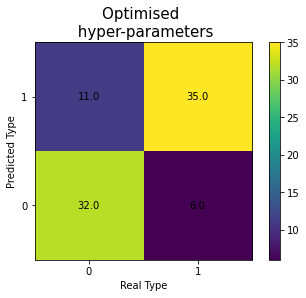

In [14]:
#initialise a regressor and postplotter to display the results
reg = Regressor(KNeighborsClassifier, fname, StratifiedKFold, cls_kwargs = eval(bestkwargs)) 
plotter = postplotter( reg.X_test, reg.y_test, reg.y_pred)
plotter.confmatrix('Optimised \n hyper-parameters')

